In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Load all datasets
print("Loading datasets...")
crop_rec1 = pd.read_csv(r'/content/drive/MyDrive/Crop_recommendation.csv')
crop_rec2 = pd.read_csv(r'/content/Crop Recommendation using Soil Properties and Weather Prediction.csv')
nutrient_data = pd.read_csv(r'/content/Nutrient.csv')





Loading datasets...


In [ ]:
print("Dataset shapes:")
print(f"Crop Recommendation 1: {crop_rec1.shape}")
print(f"Crop Recommendation 2: {crop_rec2.shape}")
print(f"Nutrition Data: {nutrient_data.shape}")

Dataset shapes:
Crop Recommendation 1: (2200, 8)
Crop Recommendation 2: (3867, 29)
Nutrition Data: (37, 31)


In [ ]:
print("\nColumn names:")
print("Crop Rec 1:", crop_rec1.columns.tolist())
print("Crop Rec 2:", crop_rec2.columns.tolist())
print("Nutrition:", nutrient_data.columns.tolist())


Column names:
Crop Rec 1: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Crop Rec 2: ['Soilcolor', 'Ph', 'K', 'P', 'N', 'Zn', 'S', 'QV2M-W', 'QV2M-Sp', 'QV2M-Su', 'QV2M-Au', 'T2M_MAX-W', 'T2M_MAX-Sp', 'T2M_MAX-Su', 'T2M_MAX-Au', 'T2M_MIN-W', 'T2M_MIN-Sp', 'T2M_MIN-Su', 'T2M_MIN-Au', 'PRECTOTCORR-W', 'PRECTOTCORR-Sp', 'PRECTOTCORR-Su', 'PRECTOTCORR-Au', 'WD10M', 'GWETTOP', 'CLOUD_AMT', 'WS2M_RANGE', 'PS', 'label']
Nutrition: ['State', 'District', 'n_High', 'n_Medium', 'n_Low', 'p_High', 'p_Medium', 'p_Low', 'k_High', 'k_Medium', 'k_Low', 'OC_High', 'OC_Medium', 'OC_Low', 'pH_Alkaline', 'pH_Acidic', 'pH_Neutral', 'EC_NonSaline', 'EC_Saline', 'S_Sufficient', 'S_Deficient', 'Fe_Sufficient', 'Fe_Deficient', 'Zn_Sufficient', 'Zn_Deficient', 'Cu_Sufficient', 'Cu_Deficient', 'B_Sufficient', 'B_Deficient', 'Mn_Sufficient', 'Mn_Deficient']


In [ ]:
def clean_crop_data(df, dataset_name):
    """Clean and preprocess crop data"""
    print(f"\nCleaning {dataset_name}...")
    df_clean = df.copy()

    # Check for missing values
    missing_values = df_clean.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Missing values in {dataset_name}:")
        print(missing_values[missing_values > 0])

        # Fill numeric missing values with median
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().sum() > 0:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)

        # For categorical columns, fill with mode
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df_clean[col].isnull().sum() > 0:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

    # Remove duplicates
    initial_size = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {initial_size - len(df_clean)} duplicates from {dataset_name}")

    return df_clean

def clean_nutrient_data(df):
    """Clean and preprocess nutrient data"""
    print("\nCleaning Nutrition Data...")
    df_clean = df.copy()

    # Handle missing values
    missing_values = df_clean.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values in Nutrition data:")
        print(missing_values[missing_values > 0])

        # Fill with median for numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().sum() > 0:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)

    # Remove duplicates
    initial_size = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {initial_size - len(df_clean)} duplicates from Nutrition data")

    return df_clean

# Clean all datasets
crop_rec1_clean = clean_crop_data(crop_rec1, "Crop Recommendation 1")
crop_rec2_clean = clean_crop_data(crop_rec2, "Crop Recommendation 2")
nutrient_clean = clean_nutrient_data(nutrient_data)


Cleaning Crop Recommendation 1...
Removed 0 duplicates from Crop Recommendation 1

Cleaning Crop Recommendation 2...
Removed 0 duplicates from Crop Recommendation 2

Cleaning Nutrition Data...
Removed 0 duplicates from Nutrition data


In [ ]:
def engineer_nutrient_features(nutrient_df):
    """Engineer features from nutrient data"""
    df = nutrient_df.copy()

    # Create composite nutrient status features
    df['N_status'] = df[['n_High', 'n_Medium', 'n_Low']].idxmax(axis=1)
    df['P_status'] = df[['p_High', 'p_Medium', 'p_Low']].idxmax(axis=1)
    df['K_status'] = df[['k_High', 'k_Medium', 'k_Low']].idxmax(axis=1)
    df['OC_status'] = df[['OC_High', 'OC_Medium', 'OC_Low']].idxmax(axis=1)

    # Create pH status (convert to categorical)
    df['pH_status'] = df[['pH_Alkaline', 'pH_Acidic', 'pH_Neutral']].idxmax(axis=1)

    # Create deficiency indicators
    df['has_deficiency'] = (
        df['S_Deficient'] + df['Fe_Deficient'] + df['Zn_Deficient'] +
        df['Cu_Deficient'] + df['B_Deficient'] + df['Mn_Deficient']
    ) > 0

    # Create nutrient balance score
    df['nutrient_balance'] = (
        df[['n_High', 'n_Medium', 'n_Low']].max(axis=1) +
        df[['p_High', 'p_Medium', 'p_Low']].max(axis=1) +
        df[['k_High', 'k_Medium', 'k_Low']].max(axis=1)
    ) / 3

    return df

def merge_with_nutrient_data(crop_df, nutrient_df, district_col=None):
    """Merge crop data with nutrient data"""
    # This is a conceptual merge - in practice, you'd need a common key like district/state
    # For demonstration, we'll create synthetic district information or use sampling

    print("Merging with nutrient data...")

    # If district information is available in crop data
    if district_col and district_col in crop_df.columns:
        merged_df = pd.merge(crop_df, nutrient_df, left_on=district_col, right_on='District', how='left')
    else:
        # Create synthetic district mapping or sample nutrient data
        # For now, we'll add nutrient data as additional features without proper merging
        print("No district column found. Adding nutrient data as additional features...")

        # Sample nutrient data to match crop data size
        nutrient_sample = nutrient_df.sample(n=len(crop_df), replace=True, random_state=42)
        nutrient_sample = nutrient_sample.reset_index(drop=True)
        crop_df = crop_df.reset_index(drop=True)

        merged_df = pd.concat([crop_df, nutrient_sample], axis=1)

    return merged_df

# Engineer nutrient features
nutrient_engineered = engineer_nutrient_features(nutrient_clean)

# Merge crop data with nutrient data (conceptual - adjust based on your actual data structure)
# For demonstration, we'll add nutrient features to both crop datasets
crop_rec1_with_nutrient = merge_with_nutrient_data(crop_rec1_clean, nutrient_engineered)
crop_rec2_with_nutrient = merge_with_nutrient_data(crop_rec2_clean, nutrient_engineered)

print(f"Crop 1 with nutrient shape: {crop_rec1_with_nutrient.shape}")
print(f"Crop 2 with nutrient shape: {crop_rec2_with_nutrient.shape}")

Merging with nutrient data...
No district column found. Adding nutrient data as additional features...
Merging with nutrient data...
No district column found. Adding nutrient data as additional features...
Crop 1 with nutrient shape: (2200, 46)
Crop 2 with nutrient shape: (3867, 67)


In [ ]:
def prepare_features(df, target_col='label'):
    """Prepare features for modeling"""
    # Separate features and target
    X = df.drop(columns=[target_col], errors='ignore')
    y = df[target_col]

    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    print(f"Numeric features: {len(numeric_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")

    # Preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return X, y, preprocessor, numeric_cols, categorical_cols

# Prepare features for both datasets
X1, y1, preprocessor1, num_cols1, cat_cols1 = prepare_features(crop_rec1_with_nutrient)
X2, y2, preprocessor2, num_cols2, cat_cols2 = prepare_features(crop_rec2_with_nutrient)

print(f"\nDataset 1 - Target classes: {y1.nunique()}")
print(f"Dataset 2 - Target classes: {y2.nunique()}")

Numeric features: 37
Categorical features: 7
Numeric features: 57
Categorical features: 8

Dataset 1 - Target classes: 22
Dataset 2 - Target classes: 12


In [ ]:
def train_and_evaluate_models(X, y, preprocessor, dataset_name):
    """Train and evaluate multiple models"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Preprocess the data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Encode target variable if needed
    if y_train.dtype == 'object':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)
    else:
        y_train_encoded = y_train
        y_test_encoded = y_test

    # Define models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(128, 64), random_state=42,
                                      max_iter=1000, early_stopping=True)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name} on {dataset_name}...")

        # Train model
        model.fit(X_train_processed, y_train_encoded)

        # Predictions
        y_pred = model.predict(X_test_processed)

        # Evaluate
        accuracy = accuracy_score(y_test_encoded, y_pred)
        cv_scores = cross_val_score(model, X_train_processed, y_train_encoded, cv=5, n_jobs=-1)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'preprocessor': preprocessor,
            'label_encoder': le if 'le' in locals() else None
        }

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

        # Detailed classification report
        if hasattr(le, 'classes_'):
            print(f"\nClassification Report for {name}:")
            print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

    return results

# Train models on both datasets
print("Training on Dataset 1 with nutrient features...")
results1 = train_and_evaluate_models(X1, y1, preprocessor1, "Dataset 1 with Nutrients")

print("\nTraining on Dataset 2 with nutrient features...")
results2 = train_and_evaluate_models(X2, y2, preprocessor2, "Dataset 2 with Nutrients")

Training on Dataset 1 with nutrient features...

Training Random Forest on Dataset 1 with Nutrients...
Random Forest Accuracy: 0.9159
Random Forest CV Score: 0.9148 (±0.0229)

Classification Report for Random Forest:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.74      0.85      0.79        20
    chickpea       1.00      1.00      1.00        20
     coconut       0.95      1.00      0.98        20
      coffee       1.00      0.95      0.97        20
      cotton       0.95      0.95      0.95        20
      grapes       1.00      1.00      1.00        20
        jute       0.71      0.85      0.77        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.81      0.65      0.72        20
       maize       0.83      0.95      0.88        20
       mango       0.95      0.95      0.95        20
   mothbeans       0.72   

In [ ]:
def create_combined_dataset(df1, df2, target_col='label'):
    """Combine both datasets for training"""
    # Find common columns
    common_cols = list(set(df1.columns) & set(df2.columns) - {target_col})

    # Ensure target column exists in both
    if target_col not in df1.columns or target_col not in df2.columns:
        raise ValueError(f"Target column '{target_col}' not found in both datasets")

    # Select common columns + target
    combined1 = df1[common_cols + [target_col]].copy()
    combined2 = df2[common_cols + [target_col]].copy()

    # Combine datasets
    combined = pd.concat([combined1, combined2], ignore_index=True)

    print(f"Combined dataset shape: {combined.shape}")
    print(f"Number of classes: {combined[target_col].nunique()}")

    return combined

# Create combined dataset
combined_data = create_combined_dataset(crop_rec1_with_nutrient, crop_rec2_with_nutrient)

# Prepare combined features
X_combined, y_combined, preprocessor_combined, _, _ = prepare_features(combined_data)

print("Training on Combined Dataset with Nutrients...")
results_combined = train_and_evaluate_models(X_combined, y_combined, preprocessor_combined, "Combined Dataset")

Combined dataset shape: (6067, 42)
Number of classes: 34
Numeric features: 33
Categorical features: 7
Training on Combined Dataset with Nutrients...

Training Random Forest on Combined Dataset...
Random Forest Accuracy: 0.3904
Random Forest CV Score: 0.3907 (±0.0089)

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Barley       0.21      0.17      0.19       101
        Bean       0.10      0.06      0.07        51
     Dagussa       0.00      0.00      0.00        14
      Fallow       0.00      0.00      0.00         5
       Maize       0.27      0.27      0.27       146
  Niger seed       0.00      0.00      0.00        13
         Pea       0.00      0.00      0.00        19
      Potato       0.50      0.30      0.38        10
  Red Pepper       0.00      0.00      0.00         6
     Sorghum       0.20      0.07      0.11        14
        Teff       0.44      0.62      0.51       252
       Wheat       0.28      0.26      0.

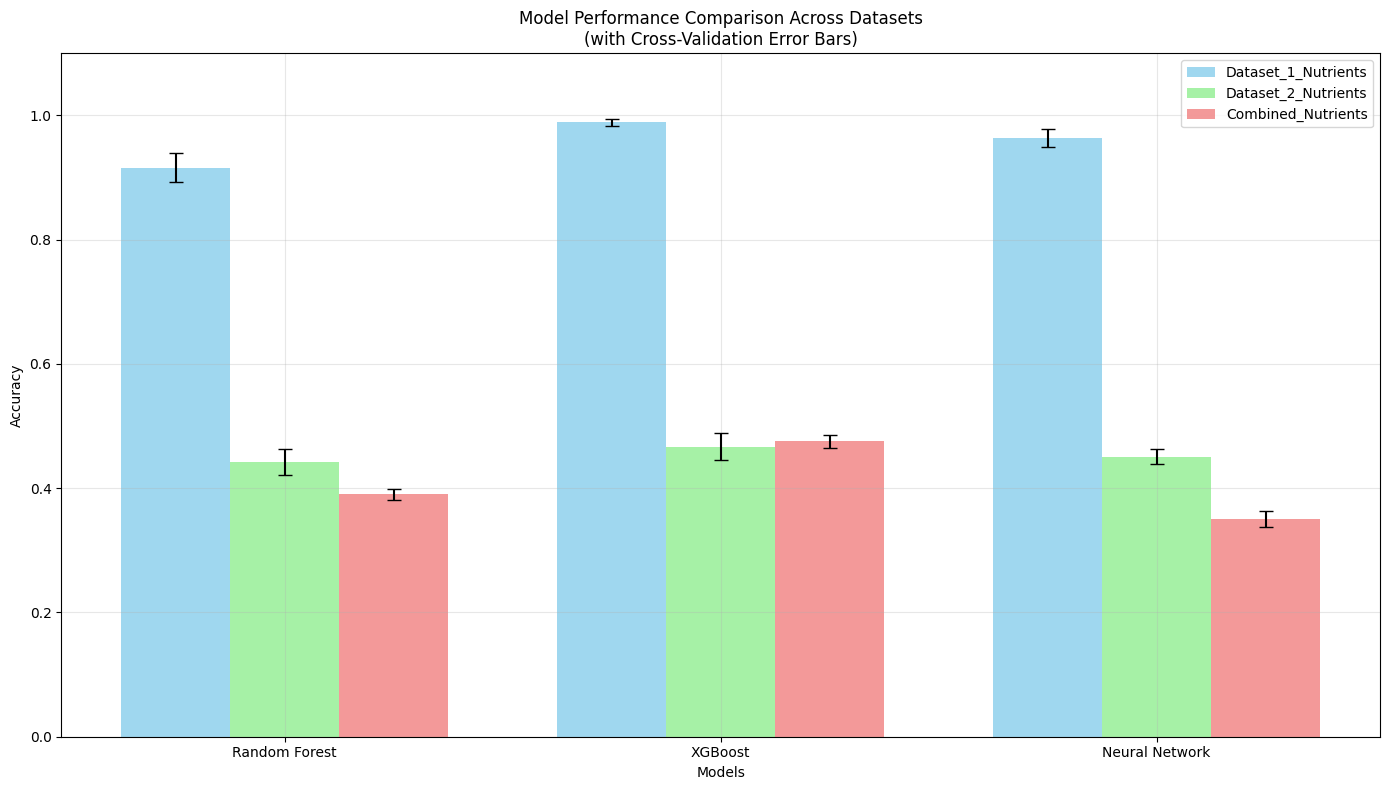


Model Comparison Summary:
            Dataset          Model  Accuracy  CV_Mean   CV_Std
Dataset_1_Nutrients  Random Forest  0.915909 0.914773 0.022939
Dataset_1_Nutrients        XGBoost  0.988636 0.988068 0.005794
Dataset_1_Nutrients Neural Network  0.963636 0.931818 0.014033
Dataset_2_Nutrients  Random Forest  0.441860 0.447132 0.021245
Dataset_2_Nutrients        XGBoost  0.466408 0.468151 0.021817
Dataset_2_Nutrients Neural Network  0.450904 0.462981 0.012496
 Combined_Nutrients  Random Forest  0.390445 0.390683 0.008931
 Combined_Nutrients        XGBoost  0.475288 0.465481 0.010806
 Combined_Nutrients Neural Network  0.350906 0.340197 0.012784


In [ ]:
def compare_all_models(results_dict):
    """Compare performance across all models and datasets"""
    comparison = []

    for dataset_name, results in results_dict.items():
        for model_name, metrics in results.items():
            comparison.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Accuracy': metrics['accuracy'],
                'CV_Mean': metrics['cv_mean'],
                'CV_Std': metrics['cv_std']
            })

    comparison_df = pd.DataFrame(comparison)

    # Visualize results
    plt.figure(figsize=(14, 8))
    colors = ['skyblue', 'lightgreen', 'lightcoral']

    for i, dataset in enumerate(comparison_df['Dataset'].unique()):
        subset = comparison_df[comparison_df['Dataset'] == dataset]
        x_pos = np.arange(len(subset)) + i * 0.25
        plt.bar(x_pos, subset['Accuracy'], width=0.25,
                label=dataset, color=colors[i], alpha=0.8)

        # Add error bars for CV standard deviation
        plt.errorbar(x_pos, subset['Accuracy'], yerr=subset['CV_Std'],
                    fmt='none', c='black', capsize=5)

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison Across Datasets\n(with Cross-Validation Error Bars)')
    plt.xticks(np.arange(3) + 0.25, comparison_df['Model'].unique())
    plt.legend()
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return comparison_df

# Compare all results
all_results = {
    'Dataset_1_Nutrients': results1,
    'Dataset_2_Nutrients': results2,
    'Combined_Nutrients': results_combined
}

comparison_df = compare_all_models(all_results)
print("\nModel Comparison Summary:")
print(comparison_df.to_string(index=False))


🎯 BEST MODEL SELECTED: XGBoost on Dataset_1_Nutrients
📊 Accuracy: 0.9886
📈 CV Score: 0.9881 (±0.0058)
✅ Best model pipeline saved as 'best_crop_recommendation_pipeline.pkl'


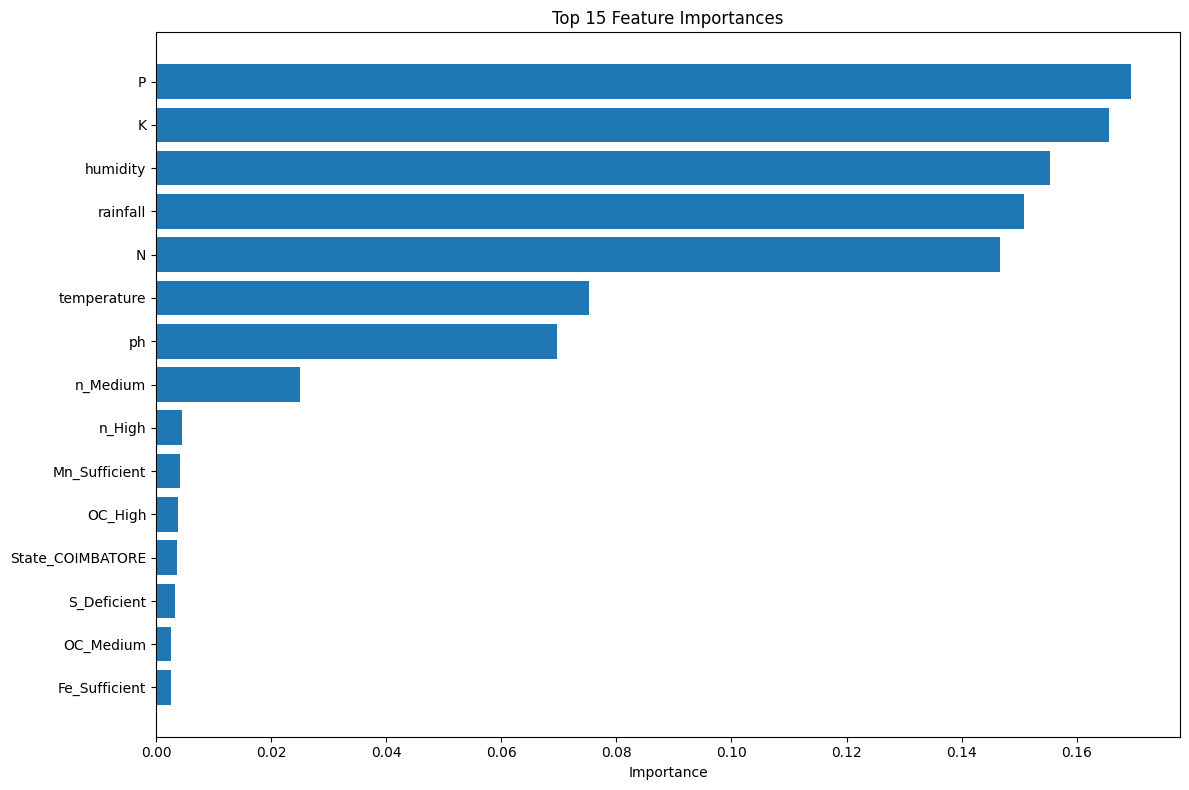

In [ ]:
def select_and_save_best_model(comparison_df, results_dict):
    """Select the best model and save it for deployment"""
    best_idx = comparison_df['Accuracy'].idxmax()
    best_model_info = comparison_df.loc[best_idx]

    dataset_name = best_model_info['Dataset']
    model_name = best_model_info['Model']

    best_result = results_dict[dataset_name][model_name]

    print(f"\n🎯 BEST MODEL SELECTED: {model_name} on {dataset_name}")
    print(f"📊 Accuracy: {best_model_info['Accuracy']:.4f}")
    print(f"📈 CV Score: {best_model_info['CV_Mean']:.4f} (±{best_model_info['CV_Std']:.4f})")

    # Save the complete pipeline
    pipeline = {
        'model': best_result['model'],
        'preprocessor': best_result['preprocessor'],
        'label_encoder': best_result.get('label_encoder'),
        'metadata': {
            'dataset': dataset_name,
            'accuracy': best_model_info['Accuracy'],
            'cv_score': best_model_info['CV_Mean'],
            'features_used': 'All features including nutrient data'
        }
    }

    joblib.dump(pipeline, 'best_crop_recommendation_pipeline.pkl')
    print("✅ Best model pipeline saved as 'best_crop_recommendation_pipeline.pkl'")

    return pipeline

# Select and save best model
best_pipeline = select_and_save_best_model(comparison_df, all_results)

# Feature importance analysis for tree-based models
if hasattr(best_pipeline['model'], 'feature_importances_'):
    try:
        # Get feature names after preprocessing
        feature_names = []

        # Numeric features
        feature_names.extend(best_pipeline['preprocessor'].transformers_[0][2])

        # Categorical features (if any were one-hot encoded)
        if len(best_pipeline['preprocessor'].transformers_) > 1:
            cat_transformer = best_pipeline['preprocessor'].transformers_[1][1]
            if hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
                cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out(
                    best_pipeline['preprocessor'].transformers_[1][2]
                )
                feature_names.extend(cat_features)

        # Plot feature importance
        importance = best_pipeline['model'].feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(15)

        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
        plt.xlabel('Importance')
        plt.title('Top 15 Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not plot feature importance: {e}")

In [ ]:
def predict_crop(features, pipeline_path='best_crop_recommendation_pipeline.pkl'):
    """Function to predict crop based on input features"""
    try:
        # Load pipeline
        pipeline = joblib.load(pipeline_path)

        # Preprocess features
        features_processed = pipeline['preprocessor'].transform(features)

        # Predict
        predictions = pipeline['model'].predict(features_processed)

        # Decode labels if encoder exists
        if pipeline['label_encoder'] is not None:
            predictions = pipeline['label_encoder'].inverse_transform(predictions)

        # Get prediction probabilities
        if hasattr(pipeline['model'], 'predict_proba'):
            probabilities = pipeline['model'].predict_proba(features_processed)
            top_probs = np.max(probabilities, axis=1)

            return predictions, top_probs
        else:
            return predictions, None

    except Exception as e:
        print(f"Prediction error: {e}")
        return None, None

# Example usage (you would need actual feature data)
print("\nExample prediction function ready to use!")
print("Call predict_crop() with your feature data to get crop recommendations")


Example prediction function ready to use!
Call predict_crop() with your feature data to get crop recommendations
